Ce notebook est destiné à calculer les performances d'un modèle classique de machine learning basé sur le de la vectorisation des textes à l'aide d'un Tf-Idf suivi d'un modèle de classification supervisée.

# Préparation de l'environnement

In [1]:
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import numpy as np
import pickle
import warnings
import mlflow
import mlflow.sklearn
from tqdm import tqdm
from utils import filter_dataset
from ml import create_ml_model
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import time


In [2]:
SEED = 314
# Define the URI of the MLflow server and the name of the experiment
URI = "http://localhost:5000"
PATH_COLS = "../data/processed/train_columns.pkl"

In [3]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialiser tqdm pour pandas
tqdm.pandas()

# Set a random seed
np.random.seed(SEED)
print("Random seed set to", SEED)

Random seed set to 314


# Chargement des données et split en train et test

On récupére les données séparées d'entrainement et de test lors de l'analyse exploratoire.

In [4]:
# Load the pickle file containing the columns
with open(PATH_COLS, "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")

Afin d'éviter de réaliser à nouveau les prétraitements qui alourdiraient les temps d'expérimentation, on les charge directement.<br>
Si on souhaite toutefois déployer ce type de modèle en production, il sera nécessaire d'ajouter au pipeline une étape de prétraitement des données avec la fonction la plus adaptée.<br>


Le schéma du pipeline serait alors le suivant:
- Fonction de standardisation des données (Via un column transformer)
- Tokenisation avec Spacy
- Vectorisation avec Tf-Idf
- Modèle de classification

In [5]:
cols

['hour',
 'text',
 'tokenized_text',
 'tokenized_lemma_text',
 'tokenized_cleaned_text',
 'tokenized_cleaned_text_no_punct_and_digits',
 'tokenized_cleaned_lemma_text_no_punct_and_digits']

# Modélisation

Je vais évaluer diffèrentes architectures de réseaux de neurones pour la classification de tweets en fonction de leur sentiment.<br>
Voici un résumé de la méthodologie que je vais suivre:

**Environnement de test**:<br>
Je vais utiliser un environnement CPU classique avec Scikit-Learn.<br>

**Jeu d'entrainement et de test**:<br>
J'utiliserai le jeu de données d'entrainement et de test déjà préparé à la fin de l'analyse exploratoire et d'avoir une base de travail comparable avec les différents pré-traitements.<br>
A noter que le jeu de validation ici est un jeu de données unique et ne sera pas testé en validation croisée comme sur les modèles de machine learning classique.<br>

**Préparation des données - tokenisation**:<br>
J'ai décidé de conserver le même modèle de tokenisation que pour les modèles de machine learning classique pour garder une cohérence dans les résultats.<br>
Ce dernier a été enregistré en tant que modèle dans MLFlow pour pouvoir être réutilisé facilement.<br>
Toutefois, ici, j'utiliserai déjà les données préparées pour éviter de les recalculer à chaque fois.<br>
Les données brutes ont été tokenisées avec le modèle `en_core_web_sm` de Spacy sous deux différentes formes:
- **Données brutes**: Les données sont utilisées telles quelles.
- **Données lemmatisées**: Les données sont lemmatisées. Sachant que la lemmatisation est faite avec Spacy, cette étape a été intégrée dans la tokenisation.<br>

**Préparation des données - standardisation des textes**:<br>
Pour faciliter ici les expériences et de réaliser à nouveau les prétraitements et la tokenisazion, notamment couteuse pour les lemmes, qui alourdiraient les temps d'expérimentation, on les charge directement.<br>
Si on souhaite toutefois déployer ce type de modèle en production, il sera nécessaire d'ajouter au pipeline une étape de prétraitement des données avec la fonction la plus adaptée.<br>


Le schéma du pipeline serait alors le suivant:
- `Tokenisation avec Spacy (chargement du modèle enregistré)`


Suivi du pipeline à enregistrer sous MLFlow:
- `Fonction de standardisation des données (Via un column transformer)`
- `Vectorisation avec Tf-Idf`
- `Modèle de classification`


**Les architectures testées**:<br>
L'objectif est de partir vers une architecture simple vers une architecture plus complexe pour voir l'impact sur les performances du modèle.<br>


Le fichier `ml.py`contient la fonction `create_ml_model` déploie un pipeline avec le Tf-Idf et un modèle de classification au choix.<br>



Le fichier `utils.py` contient les fonctions génériques qui sont utilisées sur tous les notebooks.<br>
Il nous suffira uniquement de préciser les paramètres du modèle à tester et ceux concernant mlflow pour lancer les tests.<br>


Voici un résumé des architectures que je vais tester:
- `Modèle tfidf + Régression logistique`: La régression logistique est un modèle simple, robuste et rapide à entrainer. Il est intéressant de voir comment il se comporte sur ce jeu de données.
- `Modèle tfidf + Multinomial NB`: Ce modèle probabilitique est souvent utilisé pour la classification de texte. Il est intéressant de voir comment il se comporte sur ce jeu de données.

Pour le travail de modélisation, je vais utiliser **un modèle de régression logistique en tant que référence** pour évaluer les performances en fonction des données préparées.<br>
Je testerai également la création des features via le Tf-Idf en fonction de différents hyperparamètres.<br>
Enfin, lorsque nous aurons trouvé le jeu de données le plus adapté, nous pourrons tester différents modèles de classification pour voir si nous pouvons améliorer les performances.


Pour enregistrer les évaluations des modèles, je créé une expérience pour le suivi des performances des modèles basé **sur la vectorisation par Tf-Idf**:

In [6]:
# Define the URI of the MLflow server and the name of the experiment
experiment = "ml_models_experiments"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)

## Evaluation des jeux de données

On va itérer par run les différentes expérimentations.<br>
Dans l'ordre, on va déjà agir sur les paramètres du Tf-Idf pour voir l'impact sur les performances du modèle en testant sur les différentes préparation de données:
- `Tokenized_text`: les données tokenizées avec Spacy
- `tokenized_lemma_text` : les données tokenizées et lemmatisées avec Spacy
- `tokenized_cleaned_text` : les données tokenizées et nettoyées avec la fonction de standardisation légère utilisée lors de l'exploration
- `tokenized_cleaned_text_no_punct_and_digits` : les données tokenizées, nettoyées et sans ponctuation et chiffres avec la fonction de standardisation légère utilisée lors de l'exploration
- `tokenized_cleaned_lemma_text_no_punct_and_digits` : les données tokenizées, lemmatisées, nettoyées et sans ponctuation et chiffres avec la fonction de standardisation légère utilisée lors de l'exploration. Je garde uniquement cette préparation pour les lemmes étant données que la simplification avancée doit profiter à un Tf-Idf plutôt que de garder du bruit avec la ponctuation et les chiffres.

In [7]:
cols

['hour',
 'text',
 'tokenized_text',
 'tokenized_lemma_text',
 'tokenized_cleaned_text',
 'tokenized_cleaned_text_no_punct_and_digits',
 'tokenized_cleaned_lemma_text_no_punct_and_digits']

### **RUN 1:** paramètres par défaut (unigram) pour évaluer les performances de la régression logistique sur les différents jeux de données.

In [8]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 1),
                min_df=5,
                strip_accents="unicode",
                stop_words=None,
                lowercase=True,
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

2025-01-12 21:20:27.331299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 21:20:28.107426: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2025-01-12 21:20:28.107511: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2025-01-12 21:20:28.112425: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2025-01-12 21:20:28.277260: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/

<Figure size 1050x700 with 0 Axes>

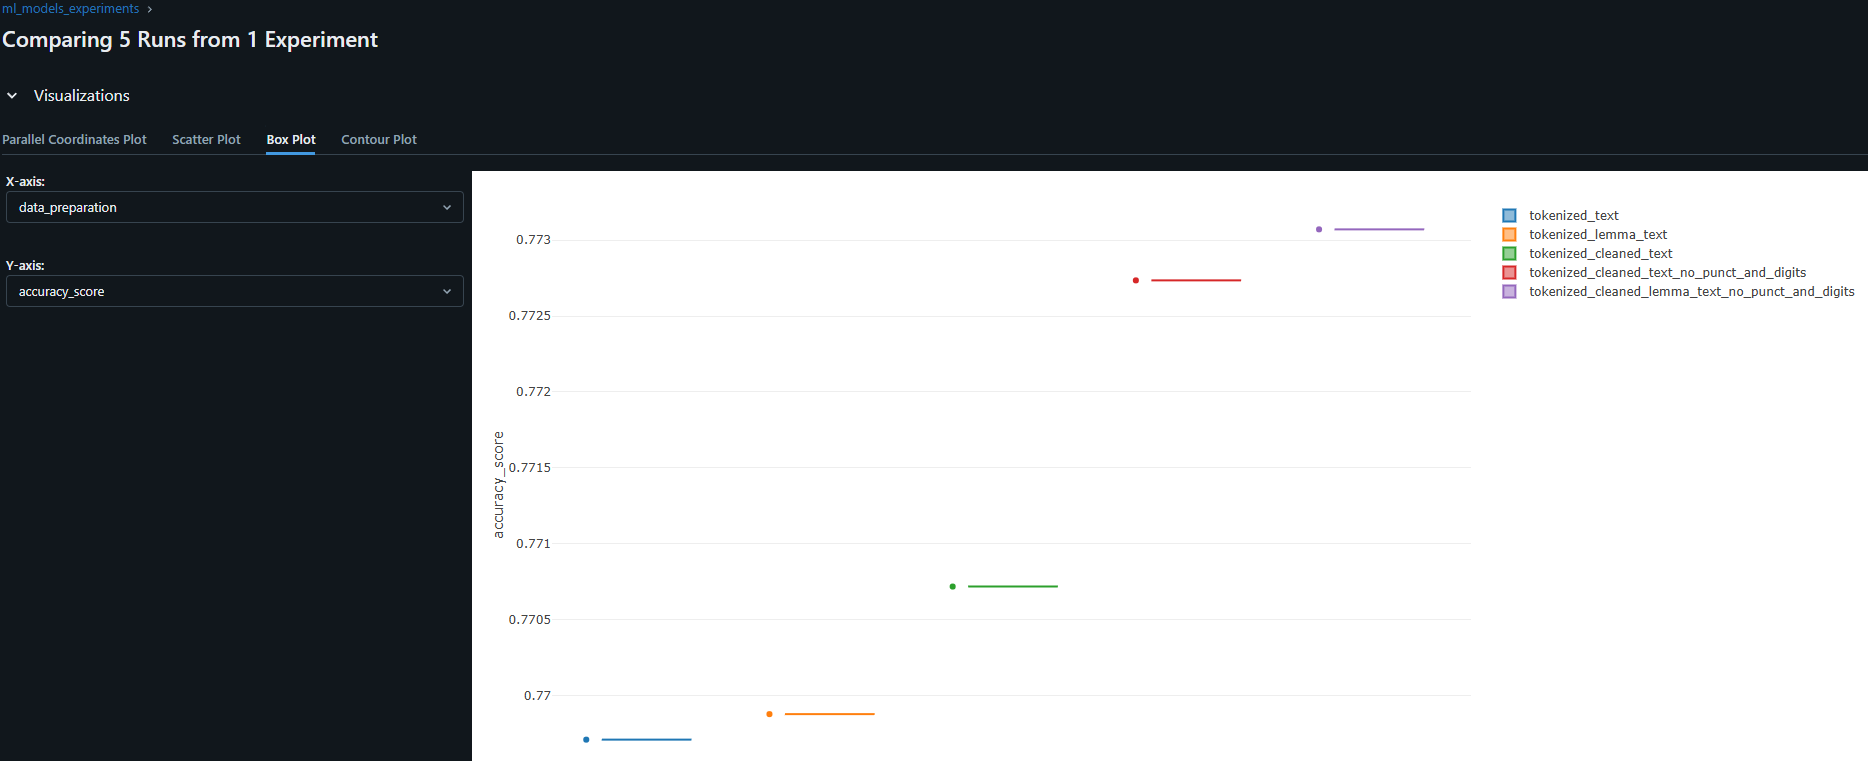

On obtient d'emblée des résultats assez prometteurs et les données lemmatisées avec la préparation avancée donnent les meilleurs résultats.<br>

### **Run 2** : Second run en ajoutant les stop words. On attends à ce que l'ajout des stop words ne soit pas forcément bénéfique avec un Tf-Idf.

In [9]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 1),
                min_df=5,
                strip_accents="unicode",
                stop_words="english",
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:21:35 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:21:35 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

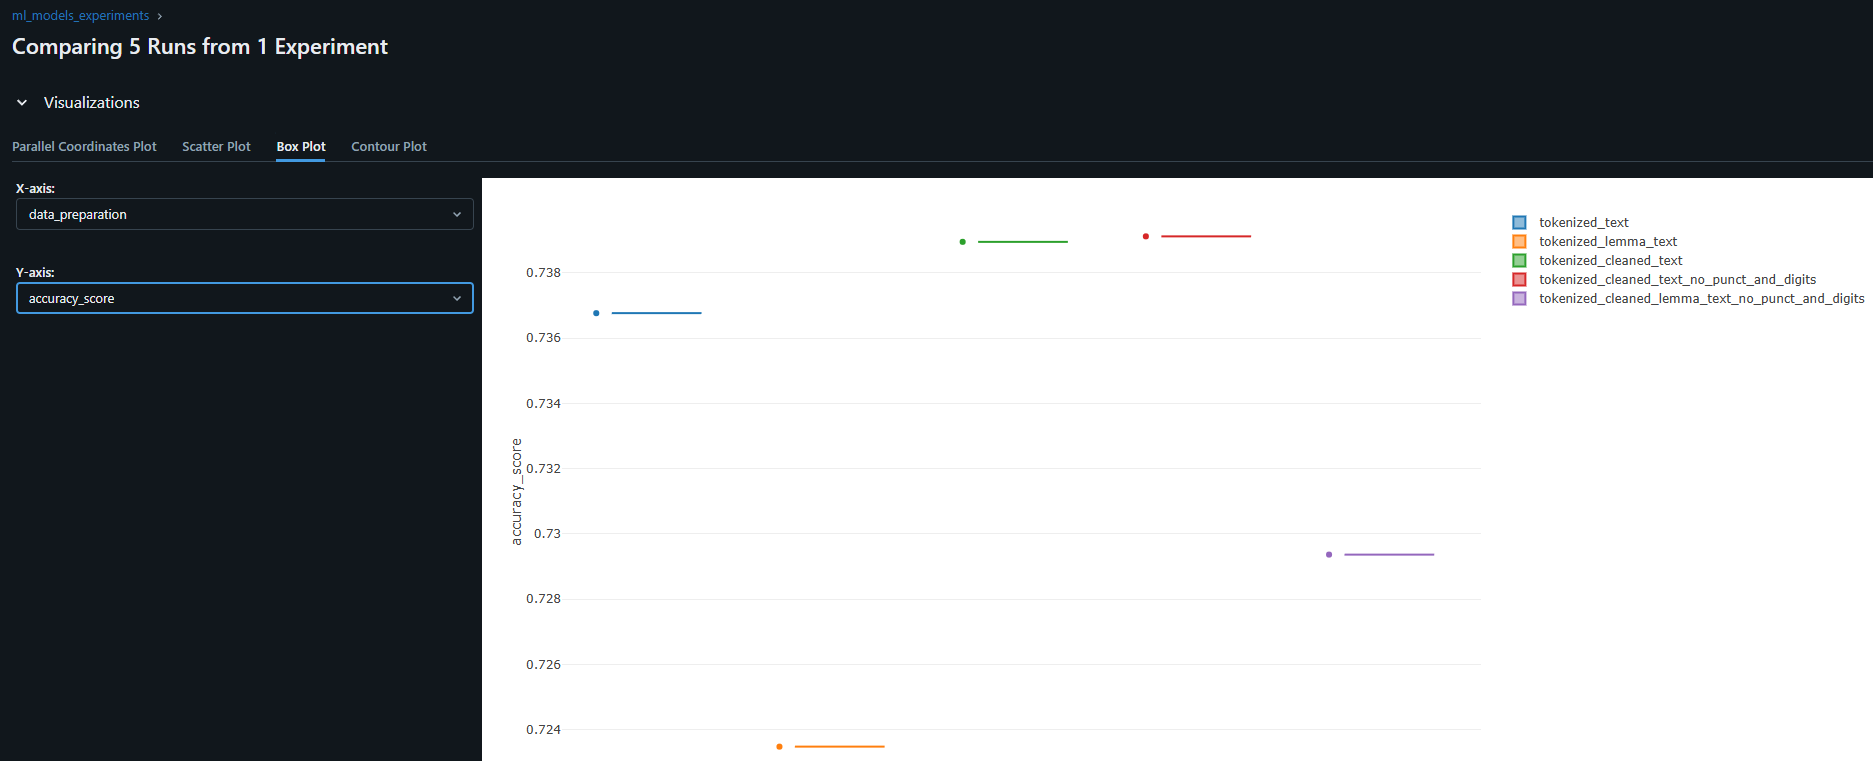

Comme attendu, l'ajout des stop words a profité davantage aux textes avec moins de nettoyage. Cela a par contre pénalisé les textes lemmatisés.

### **Run 3** : Enlever les stop words pénalisent les performances du modèle. Testons cette fois le ngram_range avec (1,2) pour voir si cela améliore les performances.

In [10]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=5,
                strip_accents="unicode",
                stop_words=None,
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:22:31 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:22:32 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

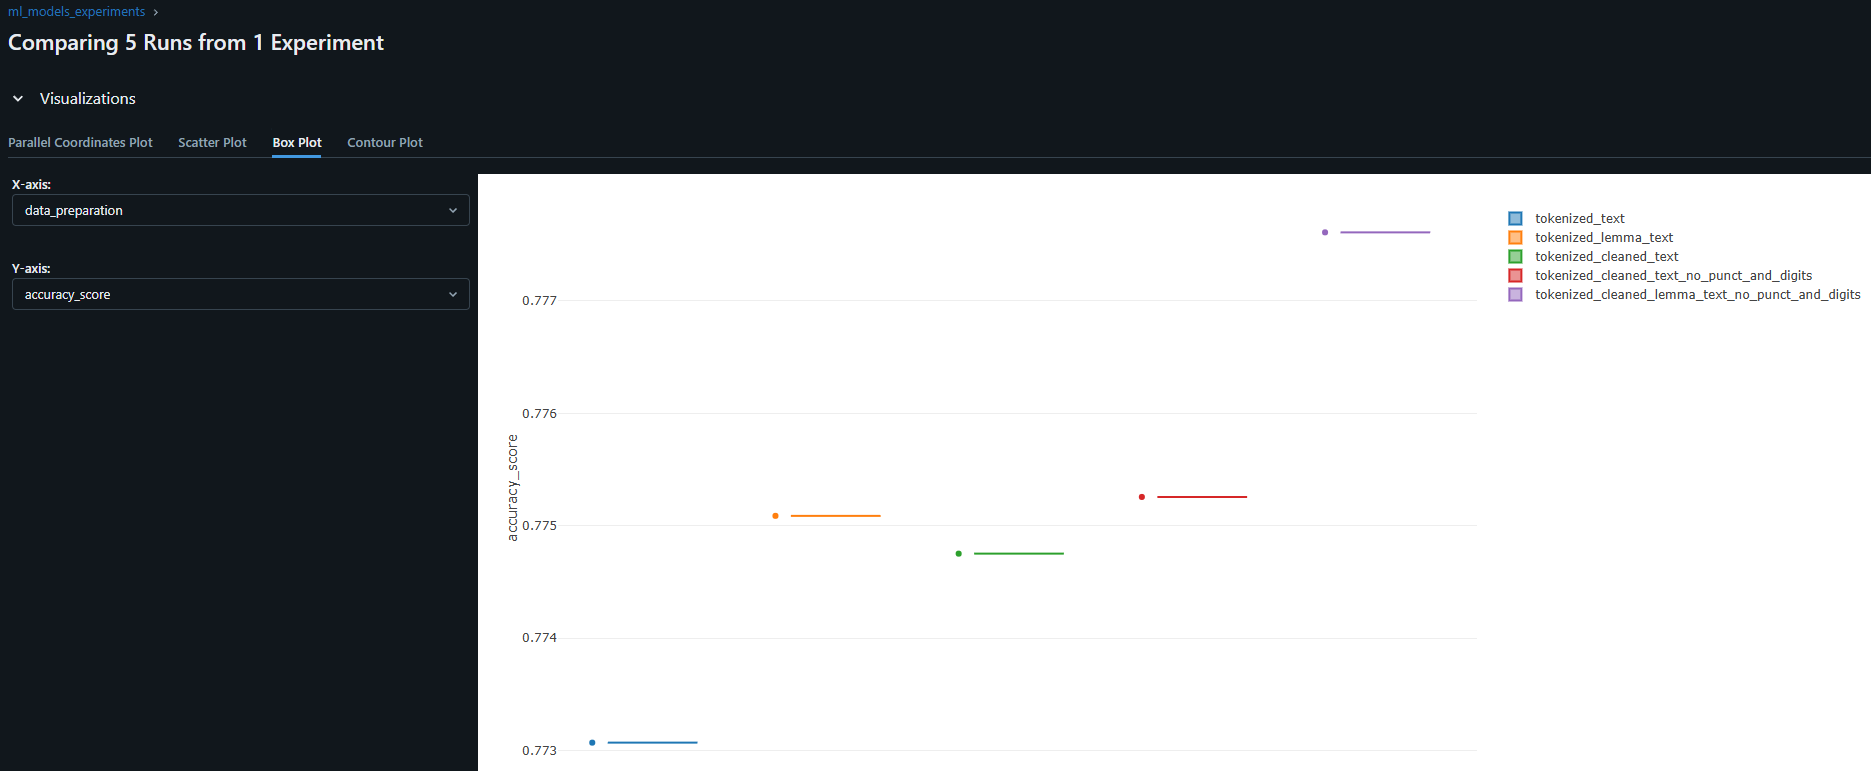

Cela améliore légèrement les performances. Poussons l'expérience avec un ngram_range de (1,3) pour voir si cela améliore les performances.

### **Run 4** : Testons le ngram_range avec (1,3) pour voir si cela améliore les performances.

In [11]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 3),
                min_df=5,
                strip_accents="unicode",
                stop_words=None,
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:23:33 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:23:33 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

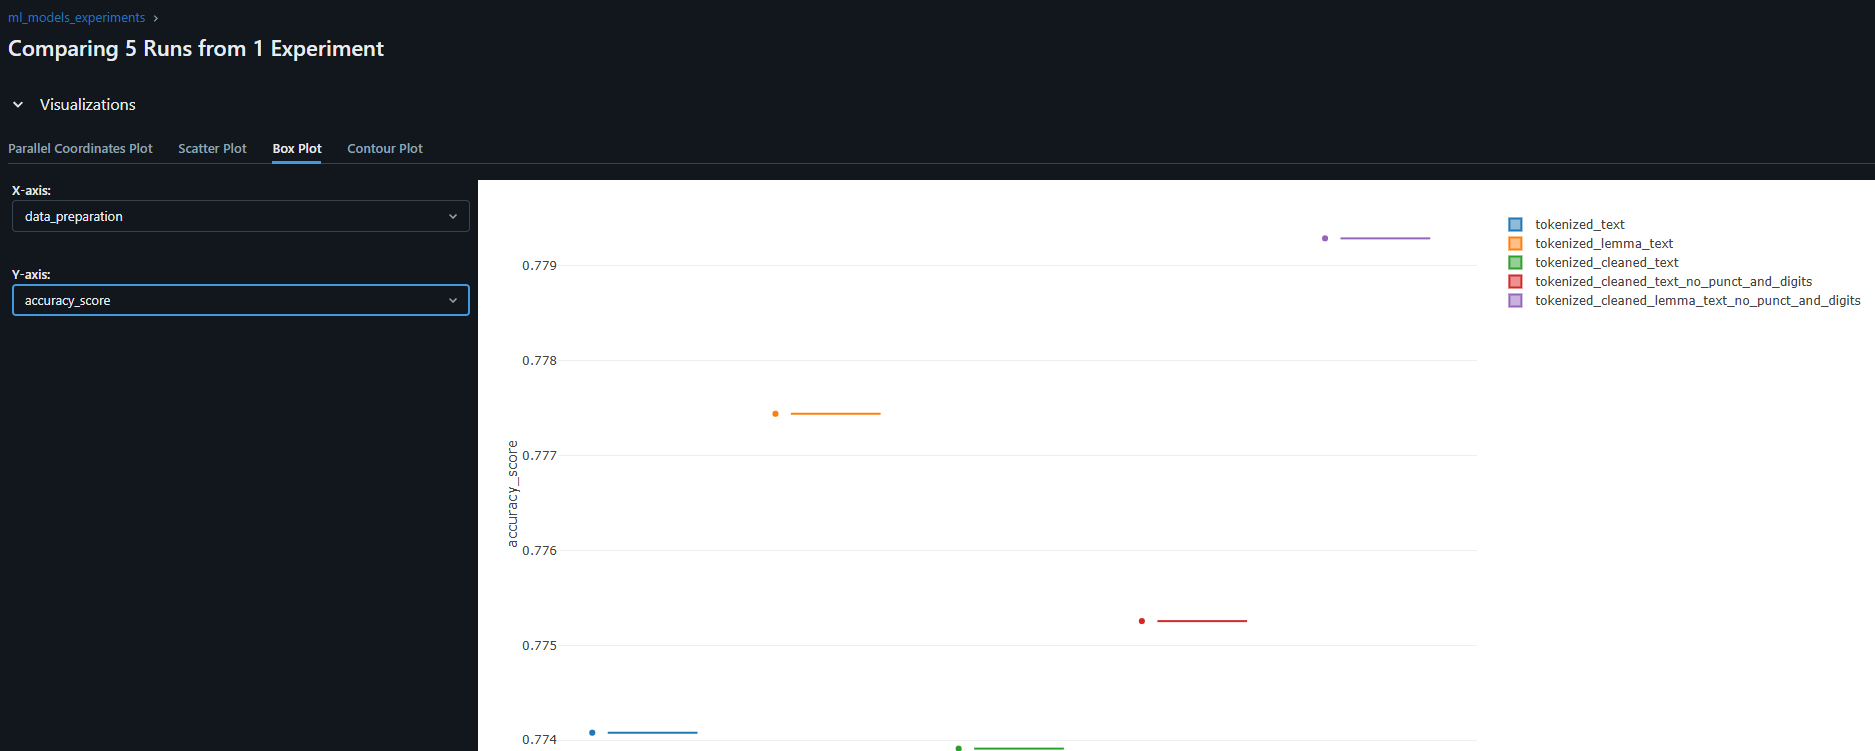

On obtient ici les meilleurs résultats. Essayons à présent d'enlever du bruit dans les données et diminuer la dimensionnalité en ajoutant un minimum de fréquence de document.

### **Run 5** : Testons avec min_df à 10 tout en conservant le ngram_range à (1,3) pour voir si cela améliore les performances.

In [12]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 3),
                min_df=10,
                strip_accents="unicode",
                stop_words=None,
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:24:38 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:24:39 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

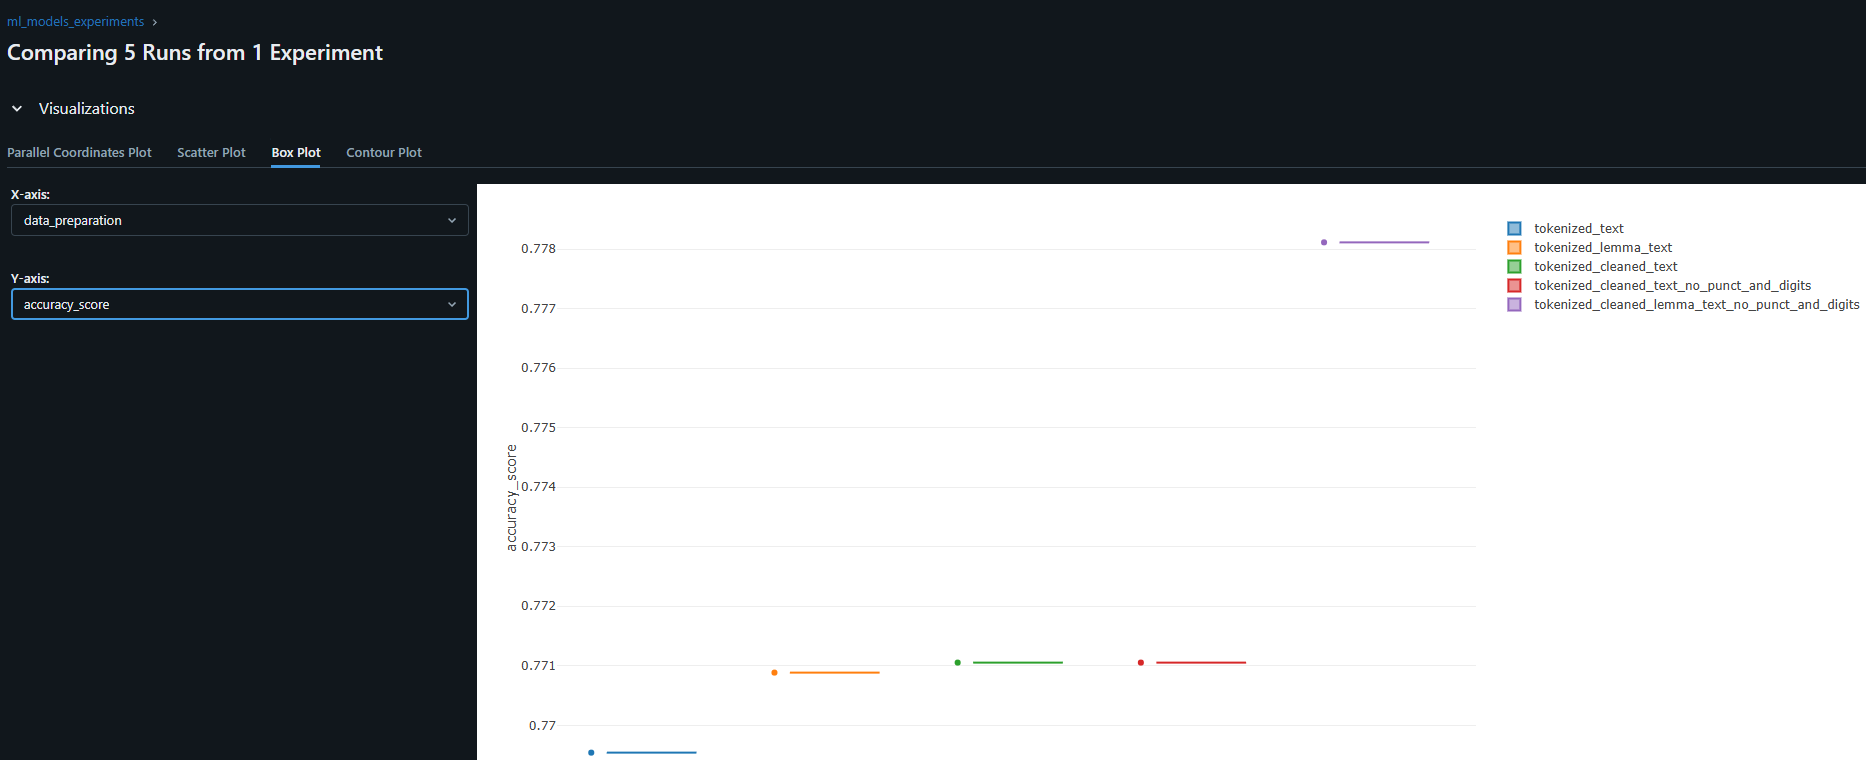

Pas d'amélioration sur les performances, voir de moins bons résultats sur la meilleure préparation.<br>
Diminuons le min_df à 3 pour voir si cela améliore les performances.

### **Run 6** : Testons avec min_df à 3 tout en conservant le ngram_range à (1,3) pour voir si cela améliore les performances.

In [13]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Start the MLflow run & autolog
    mlflow.sklearn.autolog()
    with mlflow.start_run() as active_run:
        # Set the model
        model = create_ml_model(
            col_name,
            TfidfVectorizer(
                ngram_range=(1, 3),
                min_df=3,
                strip_accents="unicode",
                stop_words=None,
            ),
            LogisticRegression(max_iter=1000, random_state=SEED),
        )
        # Cross validate the model & log the validation scores
        val_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=["accuracy", "roc_auc", "f1"],
            n_jobs=-1,
        )

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Compute the inference time & log it
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Log the additionnal metrics & parameters
        mlflow.log_metrics(
            {
                "val_accuracy": val_scores["test_accuracy"].mean(),
                "val_roc_auc": val_scores["test_roc_auc"].mean(),
                "val_f1": val_scores["test_f1"].mean(),
                "inference_time": inference_time,
            }
        )
        mlflow.log_params(
            {
                "data_preparation": col_name,
                "test_size_ratio": 0.2,
                "val_splits": len(val_scores["test_accuracy"]),
            }
        )

        # Evaluate the data on the test set with th model logged in MLflow
        evaluation_data = pd.concat([X_test, y_test], axis=1).assign(predictions=y_pred)
        model_uri = f"runs:/{active_run.info.run_id}/model"
        mlflow.evaluate(
            model=model_uri,
            model_type="classifier",
            data=evaluation_data,
            targets="target",
            predictions="predictions",
            evaluators=None,
            evaluator_config={
                "log_model_explainability": False
            },  # Disable SHAP explanations
        )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:25:44 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:25:44 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

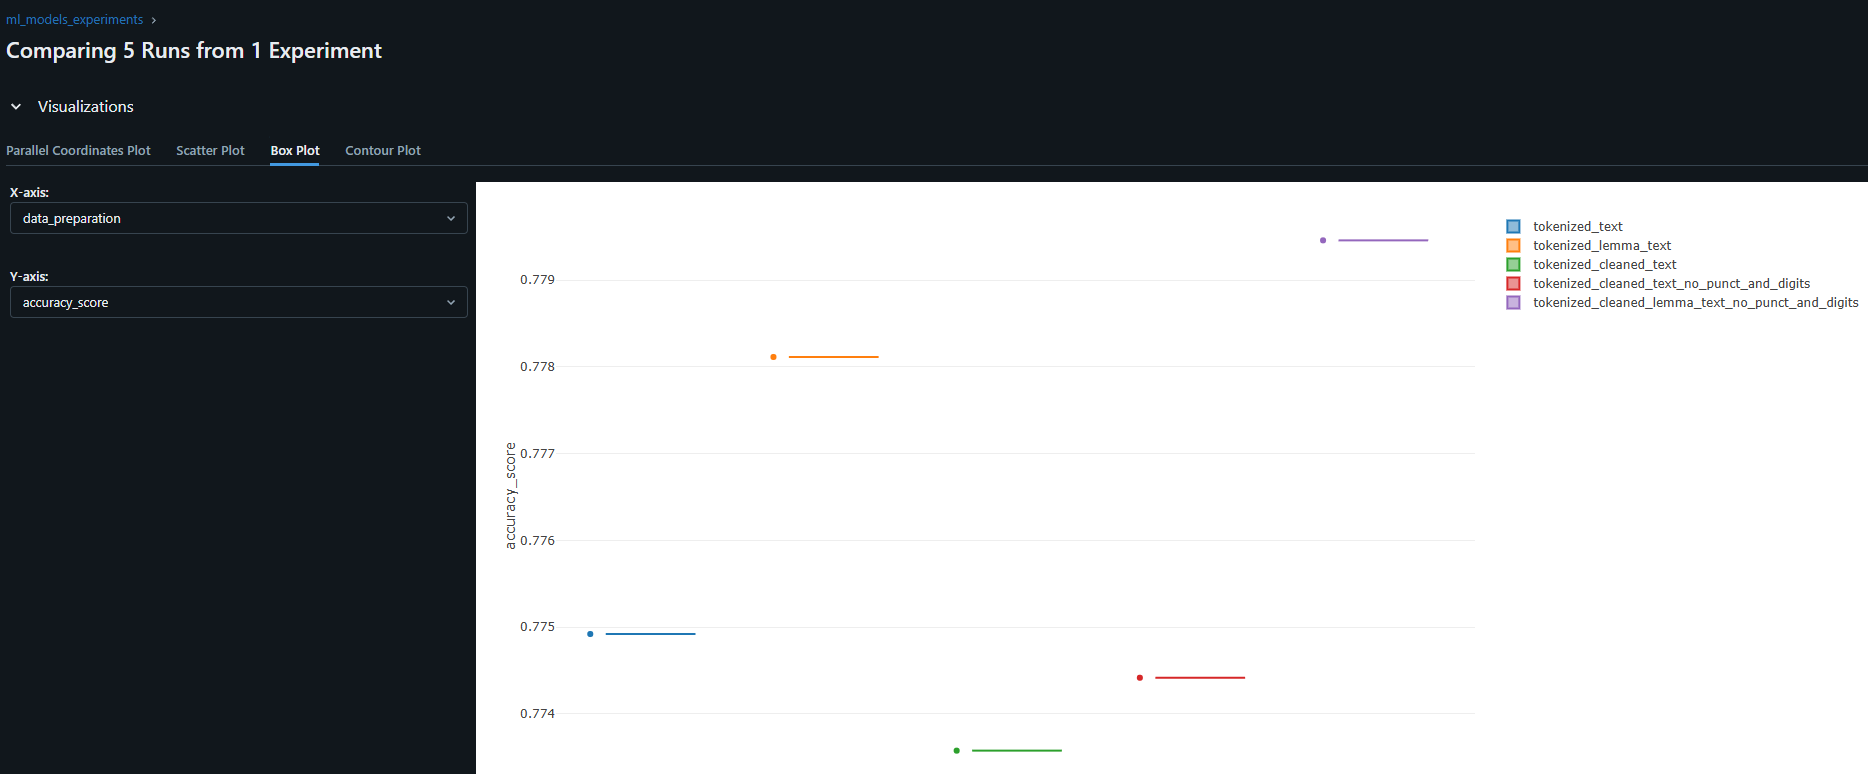

Légère amélioration des performances. Regardons comment se comporte le modèle avec l'accuracy sur le jeu d'entrainement et de test :

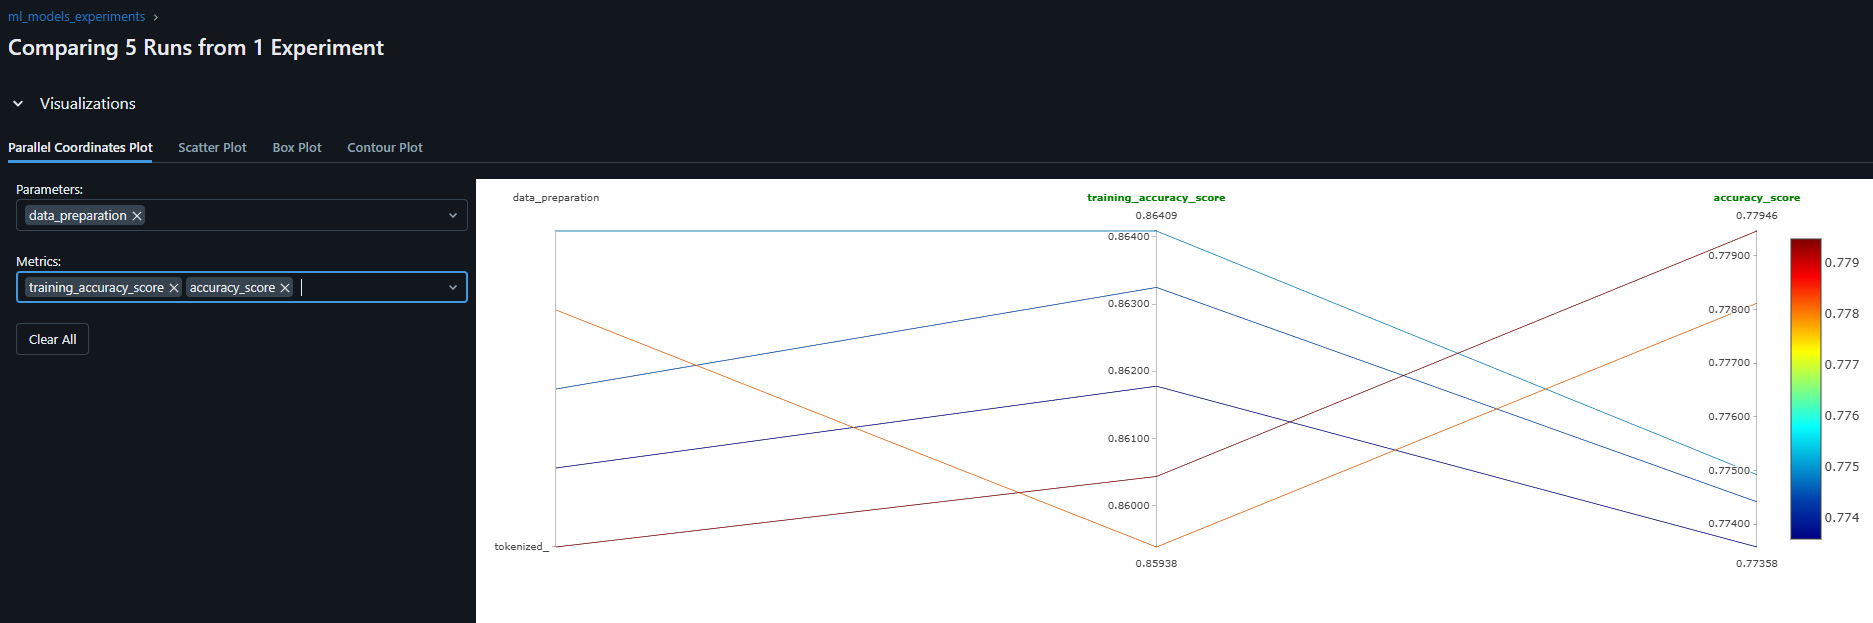

De manière généralement, on a un déséquilibre sur le tradeoff biais-variance avec une tendance à l'overfitting sur les données d'entraînement. Essayons de modifier les paramètres de régularisation sur le modèle de régression logistique pour voir si on peut améliorer les performances.

### **Run 7** : Testons différentes valeurs pour la régularisation sur la régression logistique pour voir cela améliore les résultats.

In [14]:
# Iterate through each selected dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    # Test C values for the Logistic Regression
    for c_val in (0.01, 0.1, 10, 100):
        # Start the MLflow run & autolog
        mlflow.sklearn.autolog()
        with mlflow.start_run() as active_run:
            # Set the model
            model = create_ml_model(
                col_name,
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    min_df=3,
                    strip_accents="unicode",
                    stop_words=None,
                ),
                LogisticRegression(max_iter=1000, C=c_val, random_state=SEED),
            )
            # Cross validate the model & log the validation scores
            val_scores = cross_validate(
                model,
                X_train,
                y_train,
                cv=5,
                scoring=["accuracy", "roc_auc", "f1"],
                n_jobs=-1,
            )

            # Fit the model on the training data
            model.fit(X_train, y_train)

            # Compute the inference time & log it
            start_time = time.time()
            y_pred = model.predict(X_test)
            inference_time = time.time() - start_time

            # Log the additionnal metrics & parameters
            mlflow.log_metrics(
                {
                    "val_accuracy": val_scores["test_accuracy"].mean(),
                    "val_roc_auc": val_scores["test_roc_auc"].mean(),
                    "val_f1": val_scores["test_f1"].mean(),
                    "inference_time": inference_time,
                }
            )
            mlflow.log_params(
                {
                    "data_preparation": col_name,
                    "test_size_ratio": 0.2,
                    "val_splits": len(val_scores["test_accuracy"]),
                }
            )

            # Evaluate the data on the test set with th model logged in MLflow
            evaluation_data = pd.concat([X_test, y_test], axis=1).assign(
                predictions=y_pred
            )
            model_uri = f"runs:/{active_run.info.run_id}/model"
            mlflow.evaluate(
                model=model_uri,
                model_type="classifier",
                data=evaluation_data,
                targets="target",
                predictions="predictions",
                evaluators=None,
                evaluator_config={
                    "log_model_explainability": False
                },  # Disable SHAP explanations
            )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:26:51 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:26:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

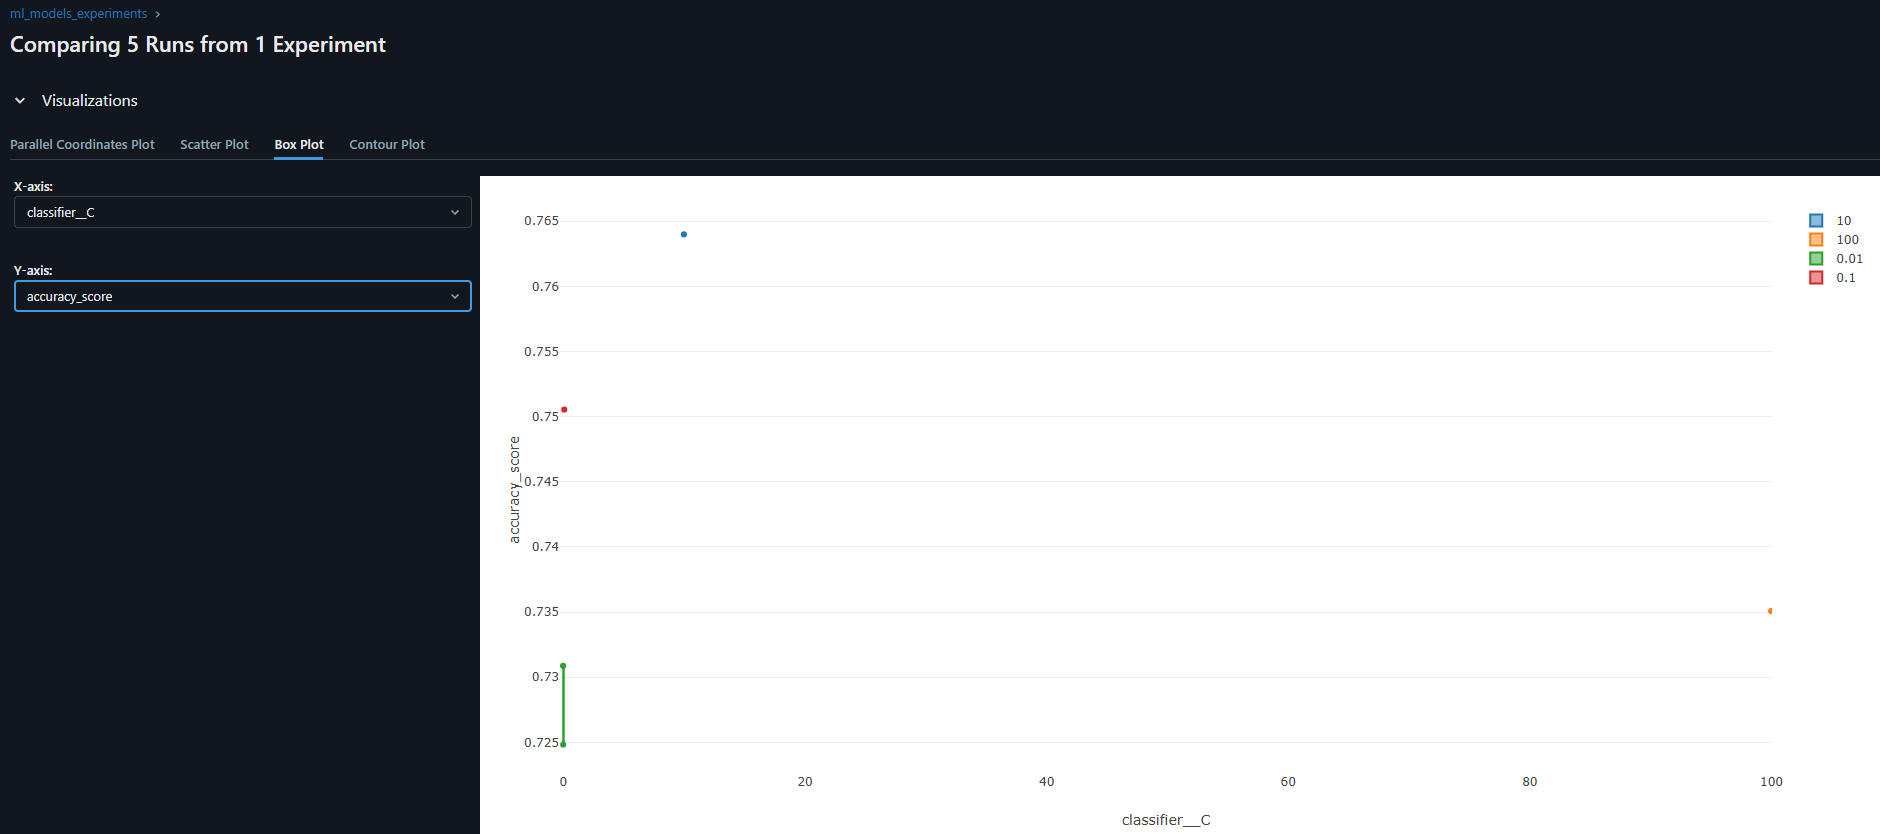

Les autres paramètres dégradent les performances du modèles, on conserve la valeur par défaut de C à 1.0.

### **Run 8** : Testons à présent un modèle MultinomialNB pour voir si cela améliore les performances avec différentes valeurs pour alpha.

In [15]:
# Iterate through each preprocessed dataset
for col_name in cols[2:]:
    # Filter the dataset to keep only the column of interest
    X_train, X_test = filter_dataset(X_train_full, X_test_full, cols=[col_name])
    for alpha_val in (0.1, 0.5, 1.0, 2.0, 5.0, 10.0):
        # Start the MLflow run & autolog
        mlflow.sklearn.autolog()
        with mlflow.start_run() as active_run:
            # Set the model
            model = create_ml_model(
                col_name,
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    min_df=3,
                    strip_accents="unicode",
                    stop_words=None,
                ),
                MultinomialNB(alpha=alpha_val),
            )
            # Cross validate the model & log the validation scores
            val_scores = cross_validate(
                model,
                X_train,
                y_train,
                cv=5,
                scoring=["accuracy", "roc_auc", "f1"],
                n_jobs=-1,
            )

            # Fit the model on the training data
            model.fit(X_train, y_train)

            # Compute the inference time & log it
            start_time = time.time()
            y_pred = model.predict(X_test)
            inference_time = time.time() - start_time

            # Log the additionnal metrics & parameters
            mlflow.log_metrics(
                {
                    "val_accuracy": val_scores["test_accuracy"].mean(),
                    "val_roc_auc": val_scores["test_roc_auc"].mean(),
                    "val_f1": val_scores["test_f1"].mean(),
                    "inference_time": inference_time,
                }
            )
            mlflow.log_params(
                {
                    "data_preparation": col_name,
                    "test_size_ratio": 0.2,
                    "val_splits": len(val_scores["test_accuracy"]),
                }
            )

            # Evaluate the data on the test set with th model logged in MLflow
            evaluation_data = pd.concat([X_test, y_test], axis=1).assign(
                predictions=y_pred
            )
            model_uri = f"runs:/{active_run.info.run_id}/model"
            mlflow.evaluate(
                model=model_uri,
                model_type="classifier",
                data=evaluation_data,
                targets="target",
                predictions="predictions",
                evaluators=None,
                evaluator_config={
                    "log_model_explainability": False
                },  # Disable SHAP explanations
            )

/home/hedredo/miniconda310/envs/p7/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/01/12 21:31:27 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2025/01/12 21:31:27 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, pos

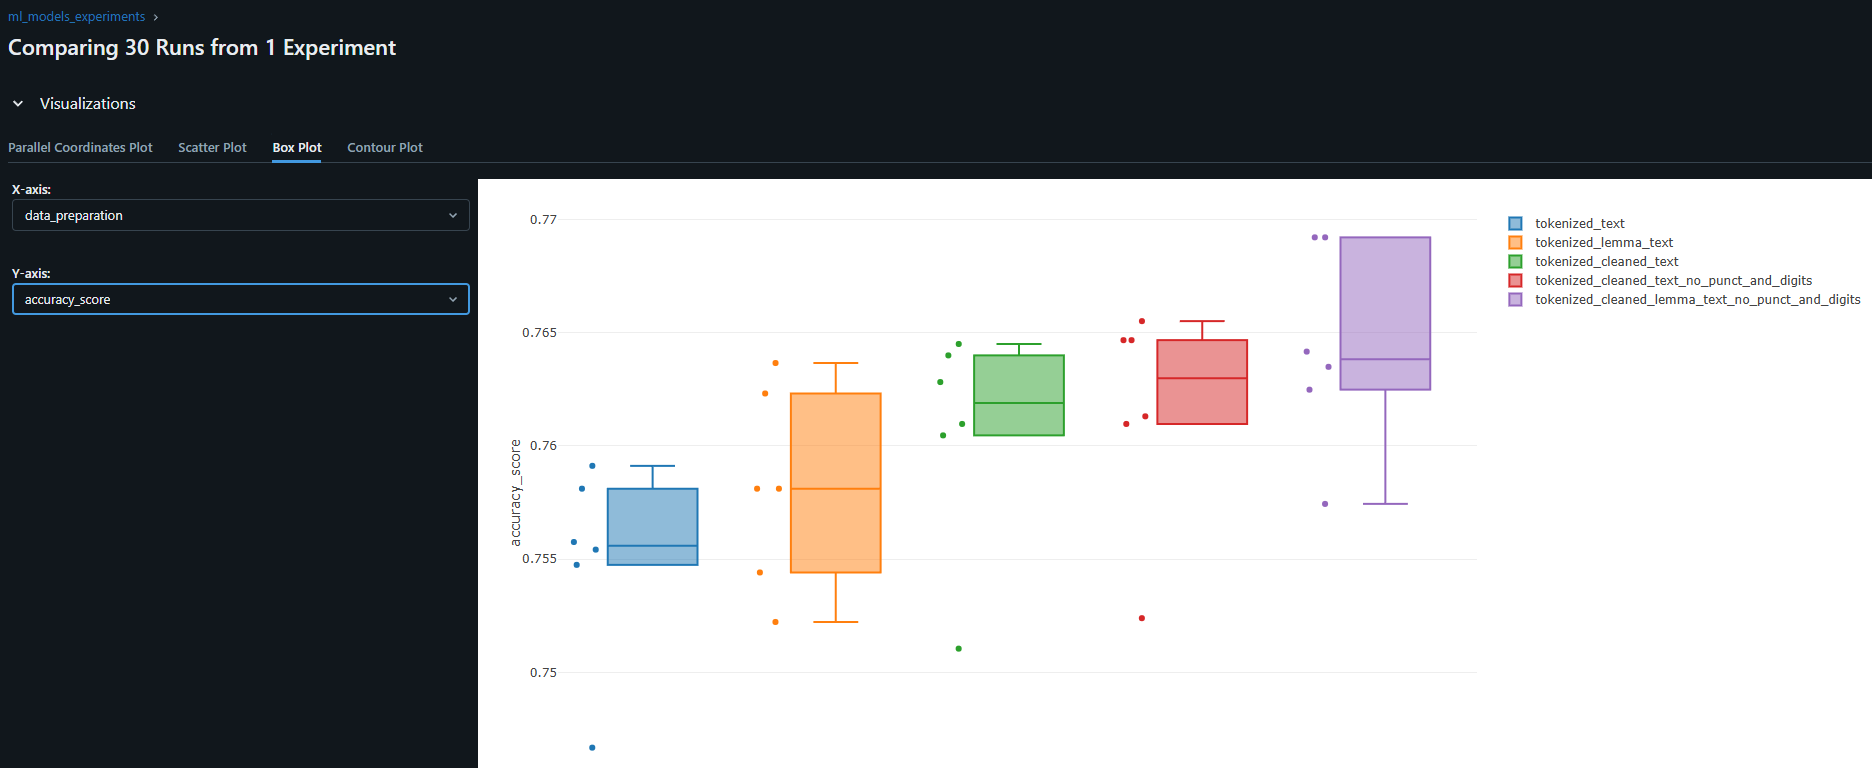

Les résultats sont moins bons que sur la régression logistique. On conserve le modèle de régression logistique pour la suite des expérimentations.<br>
On note encore une fois que les données lemmatisées avec la préparation avancée donnent les meilleurs résultats sur le modèle MultinomialNB.<br>

## Conclusion sur les modèles de régression logistique

En tête de classement, on retrouve la régression logistique avec un ngram_range de (1,3) et un min_df de 3. Les autres modèles n'ont pas réussi à surpasser les performances de la régression logistique.<br>
Les jeux de données lemmatisées donnent les meilleurs résultats pour ce type de modèle avec la standardisation avancée sur les textes.<br>

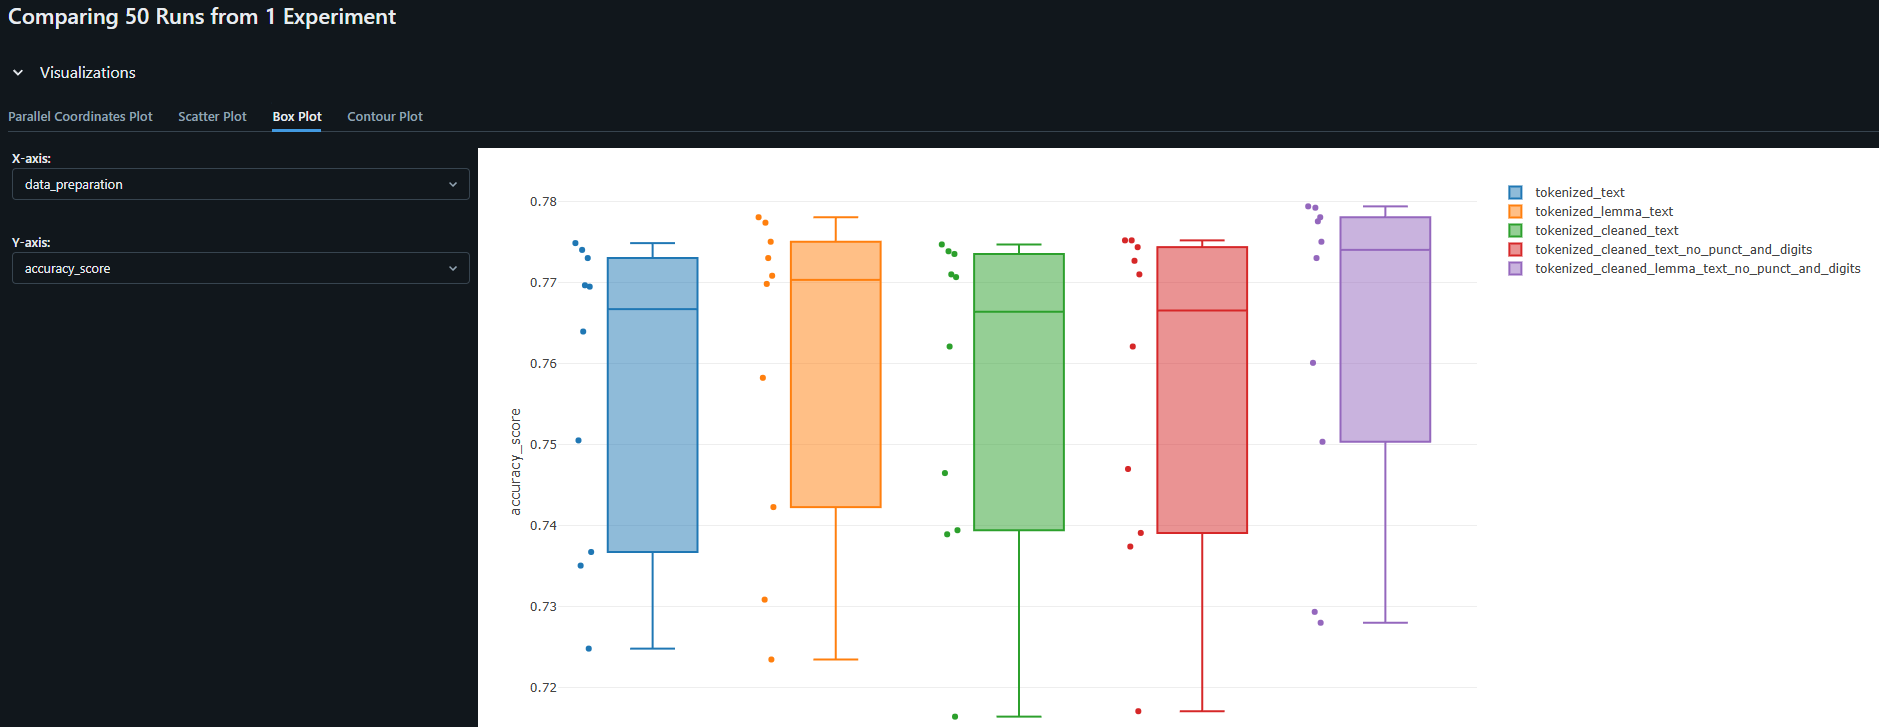